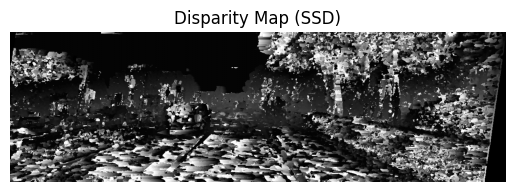

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images in grayscale
left_img = cv2.imread('000031_10_left.png', cv2.IMREAD_GRAYSCALE)
right_img = cv2.imread('000031_10_right.png', cv2.IMREAD_GRAYSCALE)

# Step 1: Detect and match features using SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(left_img, None)
kp2, des2 = sift.detectAndCompute(right_img, None)

# Feature matching using FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test
good_matches = []
pts1 = []
pts2 = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

# Step 2: Compute the Fundamental Matrix
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Select inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# Step 3: Rectify the images (uncalibrated)
_, h1, h2 = cv2.stereoRectifyUncalibrated(pts1, pts2, F, left_img.shape[::-1])

left_rectified = cv2.warpPerspective(left_img, h1, (left_img.shape[1], left_img.shape[0]))
right_rectified = cv2.warpPerspective(right_img, h2, (right_img.shape[1], right_img.shape[0]))

# Step 4: Compute disparity using SSD
def compute_disparity_SSD(left_img, right_img, window_size=5, max_disparity=64):
    height, width = left_img.shape
    disparity_map = np.zeros((height, width), np.float32)
    
    # Create a kernel for sum of squared differences
    kernel = np.ones((window_size, window_size), dtype=np.float32)

    # Precompute squared left image once
    left_sq = left_img.astype(np.float32) ** 2
    left_sq_sum = cv2.filter2D(left_sq, -1, kernel)

    # Store SSD scores for all disparities
    ssd_scores = np.full((height, width, max_disparity), np.inf)

    for d in range(max_disparity):
        shifted_right = np.roll(right_img, -d, axis=1)  # Shift right image by disparity d
        shifted_right[:, -d:] = 0  # Set wrapped-around pixels to 0

        # Compute SSD
        right_sq = shifted_right.astype(np.float32) ** 2
        right_sq_sum = cv2.filter2D(right_sq, -1, kernel)
        cross_term = cv2.filter2D(left_img.astype(np.float32) * shifted_right, -1, kernel)

        # SSD = sum(L^2) + sum(R^2) - 2 * sum(L * R)
        ssd = left_sq_sum + right_sq_sum - 2 * cross_term
        ssd_scores[:, :, d] = ssd

    # Choose disparity with the minimum SSD
    disparity_map = np.argmin(ssd_scores, axis=2)
    return disparity_map

disparity_map = compute_disparity_SSD(left_rectified, right_rectified)

# Step 5: Normalize and display disparity
disparity_normalized = cv2.normalize(disparity_map, None, 0, 255, cv2.NORM_MINMAX)
disparity_normalized = np.uint8(disparity_normalized)

plt.imshow(disparity_normalized, cmap='gray')
plt.title('Disparity Map (SSD)')
plt.axis('off')
plt.show()
